In [ ]:
!pip install shapely

# Clasificación de Lugares con Clustering K-Means

Este notebook clasifica lugares basándose en patrones de comportamiento de visitantes usando KMeans clustering.

## 1. Configuración e Importaciones

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from datetime import datetime
import os
import warnings
warnings.filterwarnings('ignore')

# Clustering
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Evaluation metrics
from sklearn.metrics import (
    silhouette_score,
    silhouette_samples,
    davies_bouldin_score,
    calinski_harabasz_score
)

# Visualization settings
%matplotlib inline
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (12, 8)

print("✓ All libraries imported successfully!")

✓ All libraries imported successfully!


## 2. Configuración

In [2]:
# File paths
DATA_FILE = '../datos/filtered_amss/sv_12_2023_location_features_amss.csv'
OUTPUT_DIR = 'results'
MODELS_DIR = os.path.join(OUTPUT_DIR, 'models')

# Clustering parameters
K_RANGE = range(2, 21)  # Test clusters from 2 to 20
OPTIMAL_K = None  # Will be determined by análisis
RANDOM_STATE = 42

# Create directories
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(MODELS_DIR, exist_ok=True)

print(f"Configuration:")
print(f"  Data file: {DATA_FILE}")
print(f"  Output directory: {OUTPUT_DIR}")
print(f"  Testing K values: {min(K_RANGE)} to {max(K_RANGE)}")

Configuration:
  Data file: ../datos/filtered_amss/sv_12_2023_location_features_amss.csv
  Output directory: results
  Testing K values: 2 to 20


## 3. Load and Explore Data

In [3]:
# Load data
df = pd.read_csv(DATA_FILE)

print(f"Datos cargados: {len(df):,} lugares")
print(f"Características: {len(df.columns)} columns")
print(f"\nFirst few rows:")
df.head()

Data loaded: 14,697 places
Features: 65 columns

First few rows:


osm_id        clase            nombre  \
0  400846765         bank  Banco Industrial   
1  400002511  residential         Palo Alto   
2  556395539      parking           parking   
3  664504345        grass             grass   
4  312566571     building             Fusal   

                                        geometry_wkt  unique_visits_weekday  \
0  POLYGON ((-89.2383563 13.6947575, -89.238334 1...                     12   
1  POLYGON ((-89.2576736 13.7101421, -89.2571881 ...                     17   
2  POLYGON ((-89.2001489 13.7046549, -89.200128 1...                     12   
3  POLYGON ((-89.2407758 13.7197677, -89.2406638 ...                     12   
4  POLYGON ((-89.2578833 13.6617643, -89.2577445 ...                      9   

   footfall_avg_per_day  unique_devices_count  \
0              1.714286                     9   
1              1.411765                    15   
2              1.300000                    11   
3              1.153846                    14   
4              1.153846                    14   

   unique_device_by_timeblock_morning  unique_device_by_timeblock_afternoon  \
0                                   4                                     7   
1                                   2                                     7   
2                                   8                                     4   
3                                   4                                     8   
4                                   5                                     6   

   unique_device_by_timeblock_evening  ...  dwell_time_median  \
0                                   1  ...                0.0   
1                                  10  ...                0.0   
2                                   0  ...                0.0   
3                                   2  ...                0.0   
4                                   4  ...                0.0   

   dwell_time_weekday_mean  dwell_time_weekend_mean  days_active  \
0                10.112500                      NaN            7   
1                48.552941                41.983333           17   
2                 0.033333                 0.000000           10   
3                 0.000000                 0.000000           13   
4                 0.000000                 5.975000           13   

   avg_visits_per_active_day  std_visits_per_day  weekend_to_weekday_ratio  \
0                   4.000000            3.366502                  0.000000   
1                   4.000000            4.415880                  0.411765   
2                   1.400000            0.699206                  0.083333   
3                   1.153846            0.375534                  0.250000   
4                   1.769231            1.363442                  0.666667   

   morning_to_evening_ratio  repeat_to_unique_ratio  avg_visits_per_device  
0                      4.00                2.111111               3.111111  
1                      0.20                3.533333               4.533333  
2                       NaN                0.272727               1.272727  
3                      2.00                0.071429               1.071429  
4                      1.25                0.642857               1.642857  

[5 rows x 65 columns]

In [4]:
# Data info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14697 entries, 0 to 14696
Data columns (total 65 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   osm_id                                14697 non-null  int64  
 1   clase                                 14697 non-null  object 
 2   nombre                                14697 non-null  object 
 3   geometry_wkt                          14697 non-null  object 
 4   unique_visits_weekday                 14697 non-null  int64  
 5   footfall_avg_per_day                  14697 non-null  float64
 6   unique_devices_count                  14697 non-null  int64  
 7   unique_device_by_timeblock_morning    14697 non-null  int64  
 8   unique_device_by_timeblock_afternoon  14697 non-null  int64  
 9   unique_device_by_timeblock_evening    14697 non-null  int64  
 10  recurrence_rate                       14697 non-null  float64
 11  avg_days_to_ret

In [5]:
# Basic statistics
df.describe()

osm_id  unique_visits_weekday  footfall_avg_per_day  \
count  1.469700e+04           14697.000000          14697.000000   
mean   6.224668e+08              24.119820              1.887879   
std    3.501758e+08              82.715842              3.781059   
min    2.792058e+06               0.000000              1.000000   
25%    3.956899e+08               1.000000              1.000000   
50%    4.249417e+08               5.000000              1.071429   
75%    9.841072e+08              16.000000              1.500000   
max    1.323271e+09            2711.000000            129.400000   

       unique_devices_count  unique_device_by_timeblock_morning  \
count          14697.000000                        14697.000000   
mean              20.646254                            8.558345   
std               61.895489                           25.638807   
min                1.000000                            0.000000   
25%                2.000000                            1.000000   
50%                4.000000                            2.000000   
75%               14.000000                            6.000000   
max             1762.000000                          732.000000   

       unique_device_by_timeblock_afternoon  \
count                          14697.000000   
mean                               9.489420   
std                               33.004959   
min                                0.000000   
25%                                1.000000   
50%                                2.000000   
75%                                6.000000   
max                             1127.000000   

       unique_device_by_timeblock_evening  recurrence_rate  \
count                        14697.000000     14697.000000   
mean                             6.516024         0.176210   
std                             22.074191         0.262436   
min                              0.000000         0.000000   
25%                              0.000000         0.000000   
50%                              1.000000         0.055556   
75%                              4.000000         0.250000   
max                            800.000000         1.000000   

       avg_days_to_return  peak_hour_weekday  ...  dwell_time_median  \
count         7701.000000       13647.000000  ...       14697.000000   
mean             5.234868          12.088737  ...          31.677321   
std              4.072599           5.262740  ...         148.023587   
min              1.000000           0.000000  ...           0.000000   
25%              2.200000           8.000000  ...           0.000000   
50%              4.200000          12.000000  ...           0.000000   
75%              7.000000          16.000000  ...           0.000000   
max             28.000000          23.000000  ...        1411.850000   

       dwell_time_weekday_mean  dwell_time_weekend_mean   days_active  \
count             13647.000000             10701.000000  14697.000000   
mean                 57.720069                64.194746      9.859359   
std                 152.312041               165.353108      9.580307   
min                   0.000000                 0.000000      1.000000   
25%                   0.000000                 0.000000      2.000000   
50%                   0.837179                 0.327778      6.000000   
75%                  31.500000                32.500877     16.000000   
max                1350.172500              1402.497917     30.000000   

       avg_visits_per_active_day  std_visits_per_day  \
count               14697.000000        11853.000000   
mean                    6.954064            4.290139   
std                    44.013204           13.905101   
min                     1.000000            0.000000   
25%                     1.000000            0.447214   
50%                     1.555556            1.154701   
75%                     3.272727            3.383785   
max                  2463.000000          465.370578   

 

In [6]:
# Check for missing values
missing = df.isnull().sum()
missing = missing[missing > 0].sort_values(ascending=False)

if len(missing) > 0:
    print("\nColumns with missing values:")
    print(missing)
    print(f"\nTotal lugares: {len(df)}")
else:
    print("\n✓ No missing values!")


Columns with missing values:
avg_days_to_return          6996
morning_to_evening_ratio    4226
peak_hour_weekend           3996
dwell_time_weekend_mean     3996
std_visits_per_day          2844
dwell_time_std              2766
peak_hour_weekday           1050
dwell_time_weekday_mean     1050
weekend_to_weekday_ratio    1050
dtype: int64

Total places: 14697


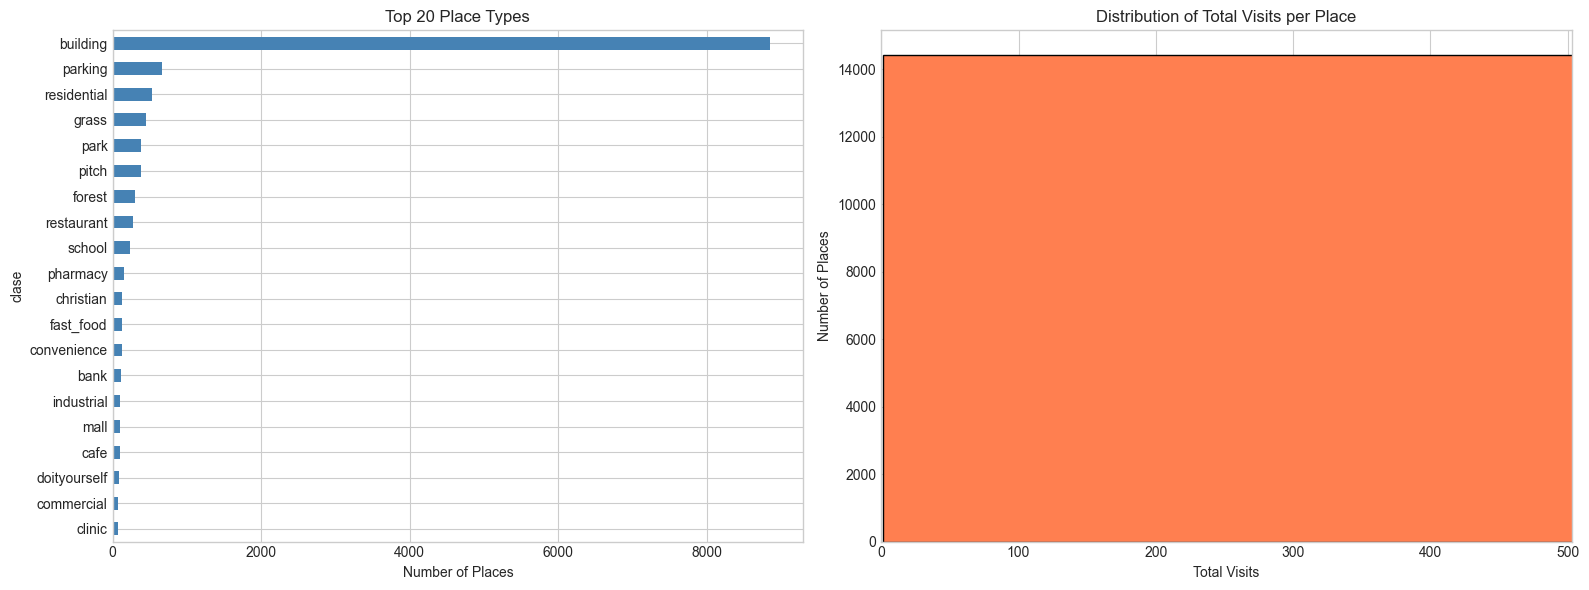


Place types: 121
Total visits across all places: 2,448,739


In [7]:
# Place type distribution
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Top place types
top_classes = df['clase'].value_counts().head(20)
top_classes.plot(kind='barh', ax=axes[0], color='steelblue')
axes[0].set_xlabel('Number of Places')
axes[0].set_title('Top 20 Place Types')
axes[0].invert_yaxis()

# Visit distribution
df['visits_total'].hist(bins=50, ax=axes[1], edgecolor='black', color='coral')
axes[1].set_xlabel('Total Visits')
axes[1].set_ylabel('Number of Places')
axes[1].set_title('Distribution of Total Visits per Place')
axes[1].set_xlim(0, df['visits_total'].quantile(0.95))  # Show 95th percentile

plt.tight_layout()
plt.show()

print(f"\nPlace types: {df['clase'].nunique()}")
print(f"Total visits across all lugares: {df['visits_total'].sum():,}")

## 4. Feature Engineering and Selección de variables

In [66]:
# Define behavioral features for clustering
# We'll group them by category for better understanding

TEMPORAL_FEATURES = [
    'unique_device_by_timeblock_morning',
    'unique_device_by_timeblock_afternoon', 
    'unique_device_by_timeblock_evening',
    'entropy_hourly_pattern',
    'entropy_daily_pattern',
    'weekend_to_weekday_ratio',
    'morning_to_evening_ratio'
]

VISITOR_FEATURES = [
    'unique_devices_count',
    'footfall_avg_per_day',
    'visits_per_device_mean',
    'median_visits_per_device',
    'recurrence_rate',
    'revisit_rate_3d',
    'revisit_rate_7d',
    'repeat_to_unique_ratio',
]

DWELL_FEATURES = [
    'dwell_time_mean',
    'dwell_time_median',
    'dwell_time_weekday_mean',
    'dwell_time_weekend_mean'
]

ACTIVITY_FEATURES = [
    'days_active',
    'avg_visits_per_active_day',
    'std_visits_per_day'
]

# Combine all features
CLUSTERING_FEATURES = (
    TEMPORAL_FEATURES + 
    VISITOR_FEATURES + 
    DWELL_FEATURES + 
    ACTIVITY_FEATURES
)

print(f"Total features for clustering: {len(CLUSTERING_FEATURES)}")
print(f"\nFeature categories:")
print(f"  Temporal patterns: {len(TEMPORAL_FEATURES)}")
print(f"  Visitor behavior: {len(VISITOR_FEATURES)}")
print(f"  Dwell time: {len(DWELL_FEATURES)}")
print(f"  Activity patterns: {len(ACTIVITY_FEATURES)}")

Total features for clustering: 22

Feature categories:
  Temporal patterns: 7
  Visitor behavior: 8
  Dwell time: 4
  Activity patterns: 3


In [67]:
# Prepare clustering dataset
# Handle missing values and filter valid lugares

df_clustering = df.copy()

# Filter lugares with minimum activity (at least 5 unique visitors)
min_visitors = 5
df_clustering = df_clustering[df_clustering['unique_devices_count'] >= min_visitors]

print(f"Places with >= {min_visitors} visitors: {len(df_clustering):,}")

# Check which features exist in the dataset
available_features = [f for f in CLUSTERING_FEATURES if f in df_clustering.columns]
missing_features = [f for f in CLUSTERING_FEATURES if f not in df_clustering.columns]

if missing_features:
    print(f"\n⚠️  Missing features: {missing_features}")
    CLUSTERING_FEATURES = available_features

print(f"\nUsing {len(CLUSTERING_FEATURES)} features for clustering")

# Extract feature matrix
X = df_clustering[CLUSTERING_FEATURES].copy()

# Handle remaining missing values
print(f"\nMissing values before imputation:")
print(X.isnull().sum()[X.isnull().sum() > 0])

# Fill missing values with median (more robust than mean)
X = X.fillna(X.median())

# Replace any remaining inf values
X = X.replace([np.inf, -np.inf], np.nan)
X = X.fillna(0)

print(f"\n✓ Feature matrix prepared: {X.shape}")
print(f"  {X.shape[0]:,} lugares × {X.shape[1]} features")

Places with >= 5 visitors: 7,260

Using 22 features for clustering

Missing values before imputation:
weekend_to_weekday_ratio      8
morning_to_evening_ratio    582
dwell_time_weekday_mean       8
dwell_time_weekend_mean     381
dtype: int64

✓ Feature matrix prepared: (7260, 22)
  7,260 places × 22 features


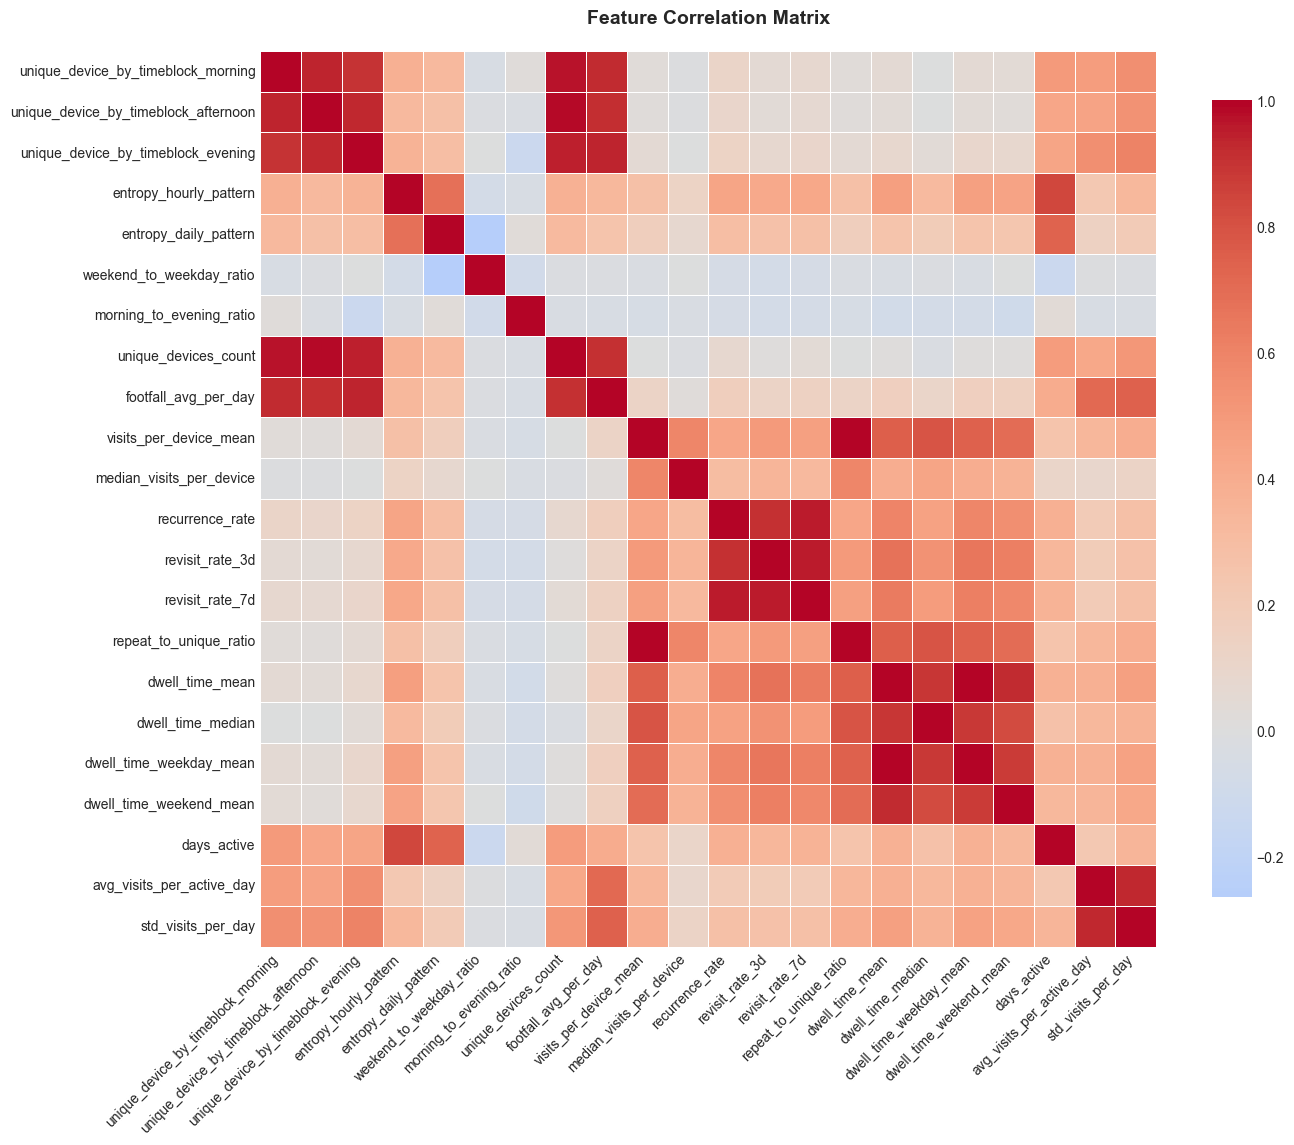


Highly correlated features (|r| > 0.8):
  visits_per_device_mean <-> repeat_to_unique_ratio: 1.000
  dwell_time_mean <-> dwell_time_weekday_mean: 0.991
  unique_device_by_timeblock_afternoon <-> unique_devices_count: 0.981
  unique_device_by_timeblock_morning <-> unique_devices_count: 0.970
  recurrence_rate <-> revisit_rate_7d: 0.958
  revisit_rate_3d <-> revisit_rate_7d: 0.955
  unique_device_by_timeblock_evening <-> unique_devices_count: 0.949
  unique_device_by_timeblock_evening <-> footfall_avg_per_day: 0.940
  unique_device_by_timeblock_morning <-> unique_device_by_timeblock_afternoon: 0.939
  unique_device_by_timeblock_afternoon <-> unique_device_by_timeblock_evening: 0.932
  avg_visits_per_active_day <-> std_visits_per_day: 0.929
  dwell_time_mean <-> dwell_time_weekend_mean: 0.924
  unique_device_by_timeblock_morning <-> footfall_avg_per_day: 0.924
  unique_device_by_timeblock_afternoon <-> footfall_avg_per_day: 0.917
  unique_devices_count <-> footfall_avg_per_day: 0.911
  r

In [68]:
# Feature correlation matrix
plt.figure(figsize=(14, 12))
correlation = X.corr()
sns.heatmap(correlation, cmap='coolwarm', center=0, 
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8},
            xticklabels=True, yticklabels=True)
plt.title('Feature Correlation Matrix', fontsize=14, fontweight='bold', pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Find highly correlated feature pairs
high_corr = []
for i in range(len(correlation.columns)):
    for j in range(i+1, len(correlation.columns)):
        if abs(correlation.iloc[i, j]) > 0.8:
            high_corr.append((
                correlation.columns[i],
                correlation.columns[j],
                correlation.iloc[i, j]
            ))

if high_corr:
    print(f"\nHighly correlated features (|r| > 0.8):")
    for f1, f2, corr in sorted(high_corr, key=lambda x: abs(x[2]), reverse=True):
        print(f"  {f1} <-> {f2}: {corr:.3f}")

## 5. Estandarización/Normalización

In [69]:
# Standardize features (mean=0, std=1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("✓ Características standardized")
print(f"  Shape: {X_scaled.shape}")
print(f"  Mean: {X_scaled.mean():.6f}")
print(f"  Std: {X_scaled.std():.6f}")

# Show before/after standardization for one feature
sample_feature = CLUSTERING_FEATURES[0]
print(f"\nExample - {sample_feature}:")
print(f"  Before: mean={X[sample_feature].mean():.2f}, std={X[sample_feature].std():.2f}")
print(f"  After:  mean={X_scaled[:, 0].mean():.2f}, std={X_scaled[:, 0].std():.2f}")

✓ Features standardized
  Shape: (7260, 22)
  Mean: 0.000000
  Std: 1.000000

Example - unique_device_by_timeblock_morning:
  Before: mean=16.46, std=34.74
  After:  mean=-0.00, std=1.00


## 6. Determine Optimal K - Elbow Method

In [70]:
print("Finding optimal number of clusters...")
print(f"Testing K from {min(K_RANGE)} to {max(K_RANGE)}")
print("This may take a few minutes...\n")

inertias = []
silhouette_scores = []
davies_bouldin_scores = []
calinski_harabasz_scores = []

for k in K_RANGE:
    # Fit KMeans
    kmeans = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    
    # Calculate metrics
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, labels))
    davies_bouldin_scores.append(davies_bouldin_score(X_scaled, labels))
    calinski_harabasz_scores.append(calinski_harabasz_score(X_scaled, labels))
    
    print(f"K={k:2d}: Inertia={kmeans.inertia_:8.1f}, Silhouette={silhouette_scores[-1]:.4f}")

print("\n✓ Analysis complete!")

Finding optimal number of clusters...
Testing K from 2 to 20
This may take a few minutes...

K= 2: Inertia=121763.0, Silhouette=0.6654
K= 3: Inertia=101535.7, Silhouette=0.6385
K= 4: Inertia= 85091.3, Silhouette=0.2625
K= 5: Inertia= 76301.9, Silhouette=0.2653
K= 6: Inertia= 68791.7, Silhouette=0.2469
K= 7: Inertia= 61780.2, Silhouette=0.2538
K= 8: Inertia= 56867.9, Silhouette=0.2537
K= 9: Inertia= 53228.0, Silhouette=0.2633
K=10: Inertia= 50240.6, Silhouette=0.1985
K=11: Inertia= 46971.4, Silhouette=0.2744
K=12: Inertia= 44108.7, Silhouette=0.2669
K=13: Inertia= 41750.9, Silhouette=0.2099
K=14: Inertia= 40126.5, Silhouette=0.2088
K=15: Inertia= 38083.4, Silhouette=0.2098
K=16: Inertia= 36732.8, Silhouette=0.2051
K=17: Inertia= 35187.3, Silhouette=0.2103
K=18: Inertia= 33942.4, Silhouette=0.2009
K=19: Inertia= 32383.2, Silhouette=0.2137
K=20: Inertia= 31184.4, Silhouette=0.2003

✓ Analysis complete!


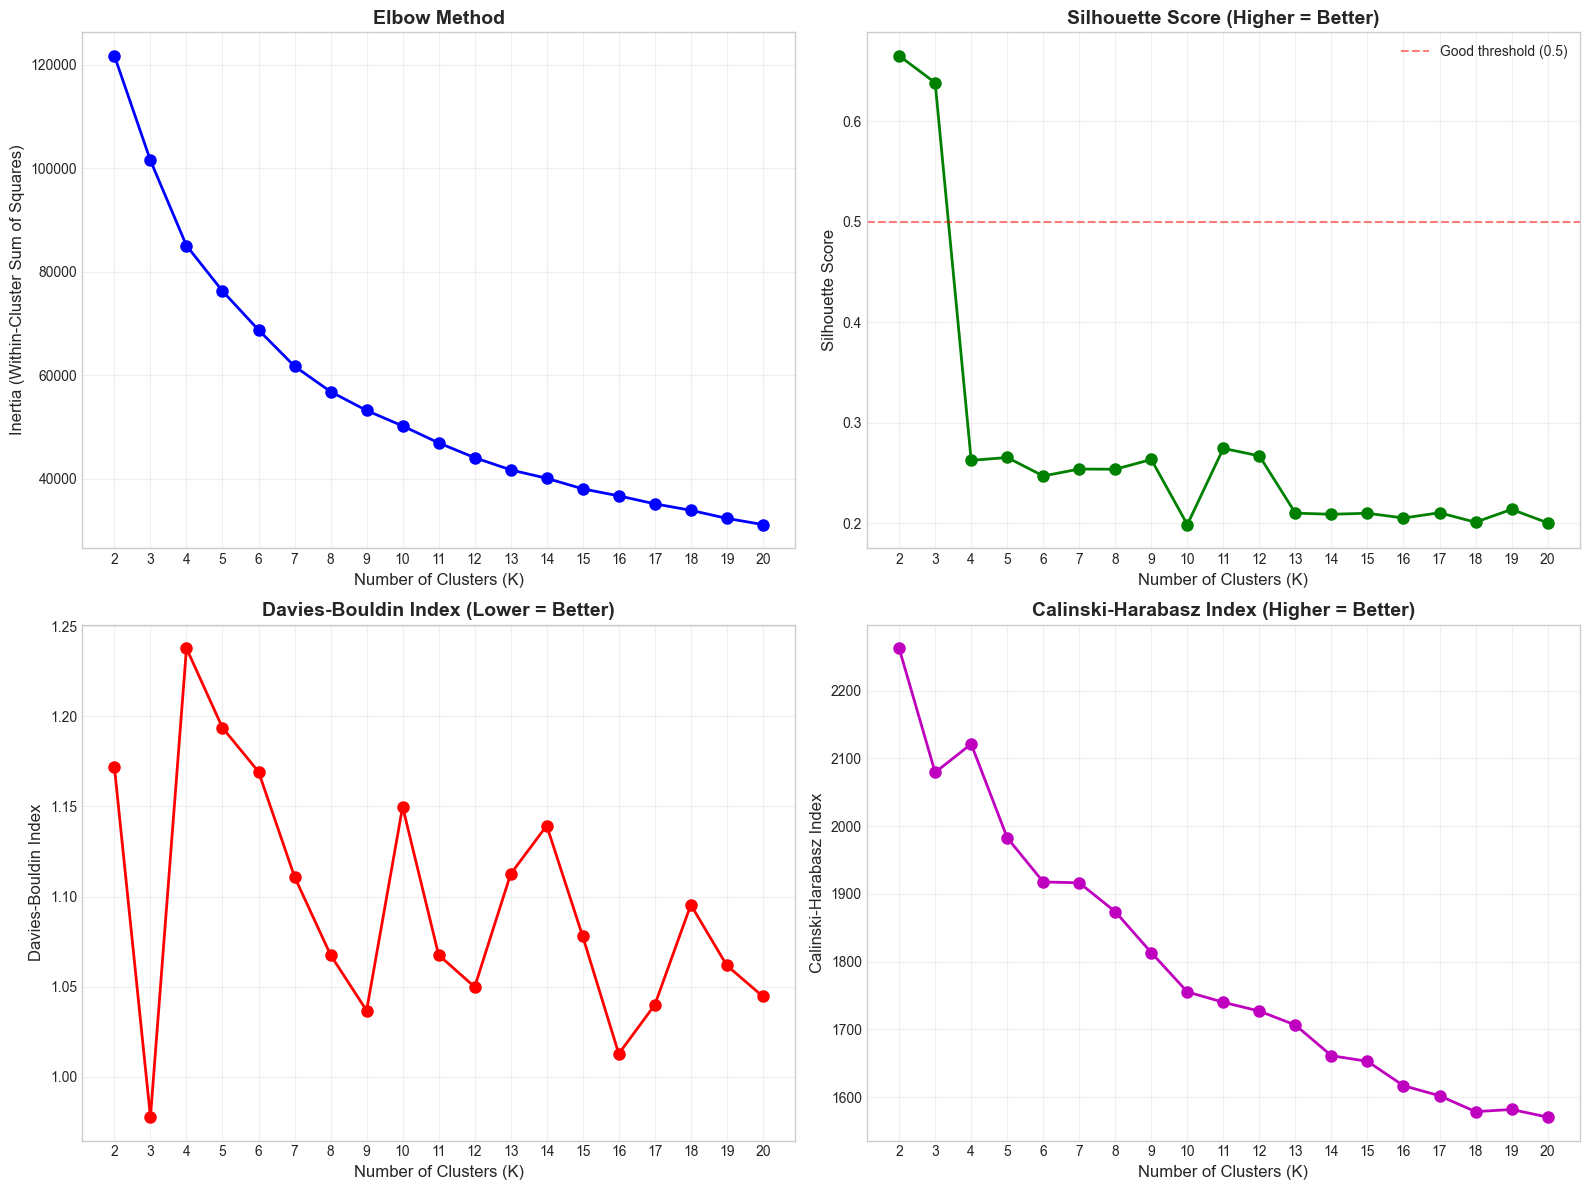

✓ Saved: results/kmeans_optimal_k_analysis.png


In [71]:
# Plot Elbow Method and evaluation metrics
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Elbow curve (Inertia)
axes[0, 0].plot(K_RANGE, inertias, 'bo-', linewidth=2, markersize=8)
axes[0, 0].set_xlabel('Number of Clusters (K)', fontsize=12)
axes[0, 0].set_ylabel('Inertia (Within-Cluster Sum of Squares)', fontsize=12)
axes[0, 0].set_title('Elbow Method', fontsize=14, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].set_xticks(K_RANGE)

# 2. Silhouette Score (higher is better)
axes[0, 1].plot(K_RANGE, silhouette_scores, 'go-', linewidth=2, markersize=8)
axes[0, 1].set_xlabel('Number of Clusters (K)', fontsize=12)
axes[0, 1].set_ylabel('Silhouette Score', fontsize=12)
axes[0, 1].set_title('Silhouette Score (Higher = Better)', fontsize=14, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].set_xticks(K_RANGE)
axes[0, 1].axhline(y=0.5, color='r', linestyle='--', alpha=0.5, label='Good threshold (0.5)')
axes[0, 1].legend()

# 3. Davies-Bouldin Index (lower is better)
axes[1, 0].plot(K_RANGE, davies_bouldin_scores, 'ro-', linewidth=2, markersize=8)
axes[1, 0].set_xlabel('Number of Clusters (K)', fontsize=12)
axes[1, 0].set_ylabel('Davies-Bouldin Index', fontsize=12)
axes[1, 0].set_title('Davies-Bouldin Index (Lower = Better)', fontsize=14, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].set_xticks(K_RANGE)

# 4. Calinski-Harabasz Index (higher is better)
axes[1, 1].plot(K_RANGE, calinski_harabasz_scores, 'mo-', linewidth=2, markersize=8)
axes[1, 1].set_xlabel('Number of Clusters (K)', fontsize=12)
axes[1, 1].set_ylabel('Calinski-Harabasz Index', fontsize=12)
axes[1, 1].set_title('Calinski-Harabasz Index (Higher = Better)', fontsize=14, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].set_xticks(K_RANGE)

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/kmeans_optimal_k_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Saved: {OUTPUT_DIR}/kmeans_optimal_k_análisis.png")

In [72]:
# Find optimal K basado en Silhouette score
optimal_k_silhouette = K_RANGE[np.argmax(silhouette_scores)]
max_silhouette = max(silhouette_scores)

# Find K with lowest Davies-Bouldin
optimal_k_db = K_RANGE[np.argmin(davies_bouldin_scores)]
min_db = min(davies_bouldin_scores)

# Find K with highest Calinski-Harabasz
optimal_k_ch = K_RANGE[np.argmax(calinski_harabasz_scores)]
max_ch = max(calinski_harabasz_scores)

print("="*70)
print("OPTIMAL K RECOMMENDATIONS")
print("="*70)
print(f"\nBy Silhouette Score: K = {optimal_k_silhouette} (score: {max_silhouette:.4f})")
print(f"By Davies-Bouldin:   K = {optimal_k_db} (score: {min_db:.4f})")
print(f"By Calinski-Harabasz: K = {optimal_k_ch} (score: {max_ch:.2f})")
print("\n💡 Recommendation: Choose K basado en Silhouette Score or domain knowledge")
print(f"   Suggested K = {optimal_k_silhouette}")
print("="*70)

OPTIMAL K RECOMMENDATIONS

By Silhouette Score: K = 2 (score: 0.6654)
By Davies-Bouldin:   K = 3 (score: 0.9778)
By Calinski-Harabasz: K = 2 (score: 2262.53)

💡 Recommendation: Choose K based on Silhouette Score or domain knowledge
   Suggested K = 2


In [73]:
# Set optimal K (you can change this basado en análisis above)
OPTIMAL_K = 3

print(f"\n✓ Selected K = {OPTIMAL_K} for final clustering")


✓ Selected K = 3 for final clustering


## 7. Train Final KMeans Model

In [74]:
# Train final model with optimal K
print(f"Training final KMeans model with K={OPTIMAL_K}...")

kmeans_final = KMeans(
    n_clusters=OPTIMAL_K,
    random_state=RANDOM_STATE,
    n_init=20,  # More initializations for better results
    max_iter=500
)

cluster_labels = kmeans_final.fit_predict(X_scaled)

# Add cluster labels to dataframe
df_clustering['cluster'] = cluster_labels

print("\n✓ Clustering complete!")
print(f"  Inertia: {kmeans_final.inertia_:.2f}")
print(f"  Iterations: {kmeans_final.n_iter_}")

# Cluster distribution
cluster_counts = pd.Series(cluster_labels).value_counts().sort_index()
print(f"\nCluster distribution:")
for cluster_id, count in cluster_counts.items():
    pct = 100 * count / len(cluster_labels)
    print(f"  Cluster {cluster_id}: {count:4d} lugares ({pct:5.2f}%)")

Training final KMeans model with K=3...

✓ Clustering complete!
  Inertia: 101535.71
  Iterations: 25

Cluster distribution:
  Cluster 0: 6790 places (93.53%)
  Cluster 1:  362 places ( 4.99%)
  Cluster 2:  108 places ( 1.49%)


## 8. Evaluación

In [116]:
# Calculate evaluation metrics
final_silhouette = silhouette_score(X_scaled, cluster_labels)
final_db = davies_bouldin_score(X_scaled, cluster_labels)
final_ch = calinski_harabasz_score(X_scaled, cluster_labels)

print("="*70)
print("FINAL MODEL EVALUATION")
print("="*70)
print(f"\nNumber of Clusters: {OPTIMAL_K}")
print(f"Number of Places: {len(cluster_labels):,}")
print(f"\nClustering Quality Metrics:")
print(f"  Silhouette Score:        {final_silhouette:.4f}")
if final_silhouette > 0.7:
    print(f"    → Excellent clustering quality")
elif final_silhouette > 0.5:
    print(f"    → Good clustering quality")
elif final_silhouette > 0.25:
    print(f"    → Acceptable clustering quality")
else:
    print(f"    → Weak clustering structure")

print(f"\n  Davies-Bouldin Index:    {final_db:.4f}")
print(f"    → Lower is better (measures separation)")

print(f"\n  Calinski-Harabasz Index: {final_ch:.2f}")
print(f"    → Higher is better (variance ratio)")
print("="*70)

FINAL MODEL EVALUATION

Number of Clusters: 3
Number of Places: 7,260

Clustering Quality Metrics:
  Silhouette Score:        0.6385
    → Good clustering quality

  Davies-Bouldin Index:    0.9778
    → Lower is better (measures separation)

  Calinski-Harabasz Index: 2079.29
    → Higher is better (variance ratio)


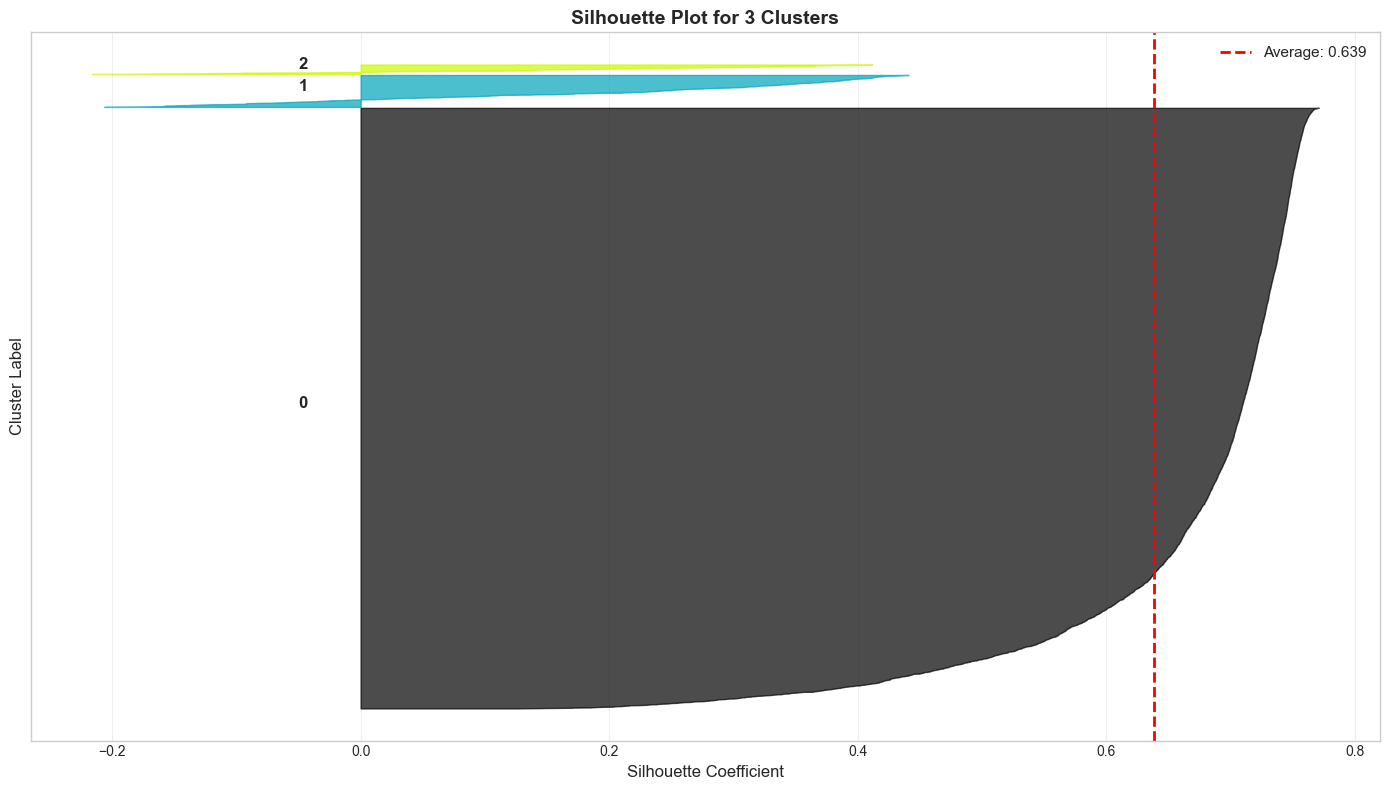

✓ Saved: results/kmeans_silhouette_analysis.png


In [117]:
# Silhouette análisis per cluster
silhouette_vals = silhouette_samples(X_scaled, cluster_labels)

fig, ax = plt.subplots(1, 1, figsize=(14, 8))

y_lower = 10
for i in range(OPTIMAL_K):
    cluster_silhouette_vals = silhouette_vals[cluster_labels == i]
    cluster_silhouette_vals.sort()

    size_cluster = cluster_silhouette_vals.shape[0]
    y_upper = y_lower + size_cluster

    color = plt.cm.nipy_spectral(float(i) / OPTIMAL_K)
    ax.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_silhouette_vals,
                     facecolor=color, edgecolor=color, alpha=0.7)

    ax.text(-0.05, y_lower + 0.5 * size_cluster, str(i), fontsize=12, fontweight='bold')
    y_lower = y_upper + 10

ax.set_xlabel('Silhouette Coefficient', fontsize=12)
ax.set_ylabel('Cluster Label', fontsize=12)
ax.set_title(f'Silhouette Plot for {OPTIMAL_K} Clusters', fontsize=14, fontweight='bold')
ax.axvline(x=final_silhouette, color="red", linestyle="--", linewidth=2,
          label=f'Average: {final_silhouette:.3f}')
ax.set_yticks([])
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/kmeans_silhouette_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Saved: {OUTPUT_DIR}/kmeans_silhouette_análisis.png")

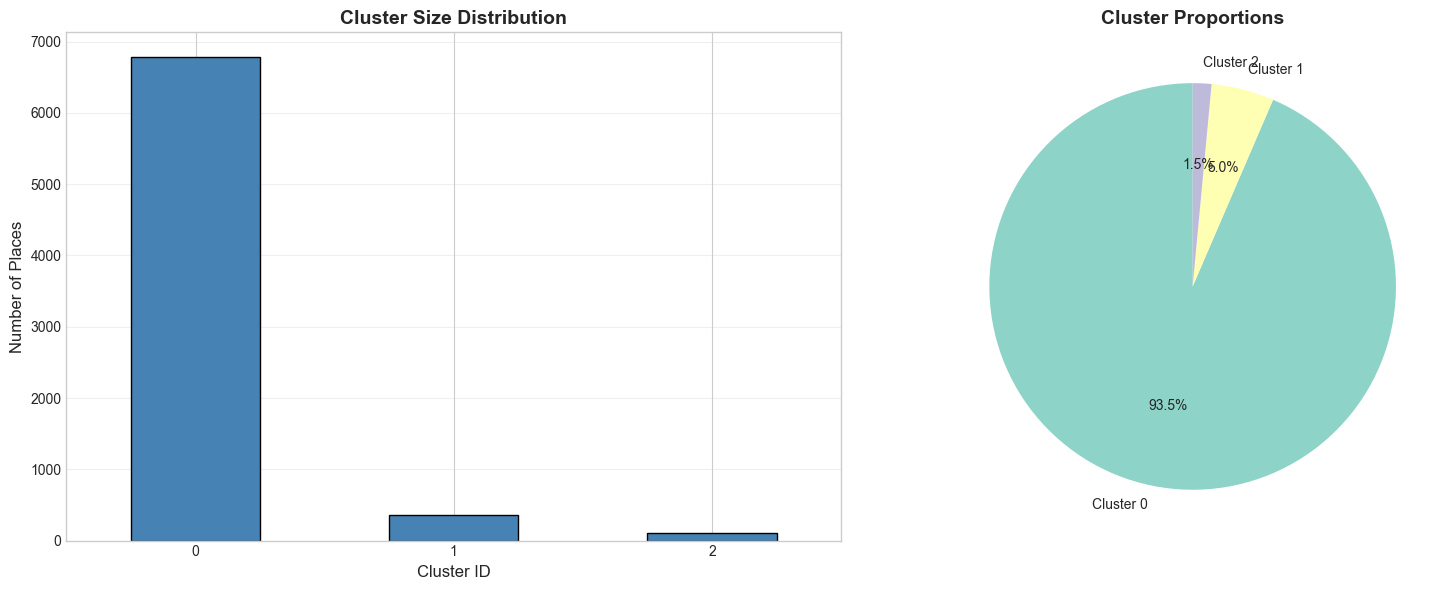

In [118]:
# Cluster size distribution
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Bar chart
cluster_counts.plot(kind='bar', ax=axes[0], color='steelblue', edgecolor='black')
axes[0].set_xlabel('Cluster ID', fontsize=12)
axes[0].set_ylabel('Number of Places', fontsize=12)
axes[0].set_title('Cluster Size Distribution', fontsize=14, fontweight='bold')
axes[0].tick_params(axis='x', rotation=0)
axes[0].grid(True, alpha=0.3, axis='y')

# Pie chart
colors = plt.cm.Set3(range(OPTIMAL_K))
axes[1].pie(cluster_counts, labels=[f"Cluster {i}" for i in range(OPTIMAL_K)],
           autopct='%1.1f%%', colors=colors, startangle=90)
axes[1].set_title('Cluster Proportions', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

## 9. Cluster Profiling

Analyze characteristics of each cluster to understand what types of lugares they represent.

In [119]:
# Calculate cluster profiles (mean values for each feature)
cluster_profiles = df_clustering.groupby('cluster')[CLUSTERING_FEATURES].mean()

# Also get median and std
cluster_median = df_clustering.groupby('cluster')[CLUSTERING_FEATURES].median()
cluster_std = df_clustering.groupby('cluster')[CLUSTERING_FEATURES].std()

print("Cluster profiles (mean values):")
cluster_profiles

Cluster profiles (mean values):


unique_device_by_timeblock_morning  \
cluster                                       
0                                 13.542268   
1                                 11.812155   
2                                215.203704   

         unique_device_by_timeblock_afternoon  \
cluster                                         
0                                   14.522091   
1                                   12.375691   
2                                  279.805556   

         unique_device_by_timeblock_evening  entropy_hourly_pattern  \
cluster                                                               
0                                  9.601767                2.197358   
1                                 12.312155                3.011832   
2                                191.601852                2.906121   

         entropy_daily_pattern  weekend_to_weekday_ratio  \
cluster                                                    
0                     1.444796                  0.443094   
1                     1.733989                  0.397176   
2                     1.765443                  0.424094   

         morning_to_evening_ratio  unique_devices_count  footfall_avg_per_day  \
cluster                                                                         
0                        2.011449             33.035346              2.186288   
1                        1.144607             21.886740              3.680083   
2                        1.190143            522.175926             34.940432   

         visits_per_device_mean  ...  revisit_rate_3d  revisit_rate_7d  \
cluster                          ...                                     
0                      3.395912  ...         0.090469         0.118342   
1                     88.927287  ...         0.519287         0.542808   
2                     23.612759  ...         0.200926         0.254735   

         repeat_to_unique_ratio  dwell_time_mean  dwell_time_median  \
cluster                                                               
0                      2.395912        35.700397           4.998378   
1                     87.927287       597.623131         569.086464   
2                     22.612759       173.004543         102.592438   

         dwell_time_weekday_mean  dwell_time_weekend_mean  days_active  \
cluster                                                                  
0                      36.328057                32.001273    15.851546   
1                     612.622131               566.350351    27.378453   
2                     177.875221               161.191258    30.000000   

         avg_visits_per_active_day  std_visits_per_day  
cluster                                                 
0                         5.215310            3.823620  
1                        58.512318           25.093625  
2                       275.056173           81.555943  

[3 rows x 22 columns]

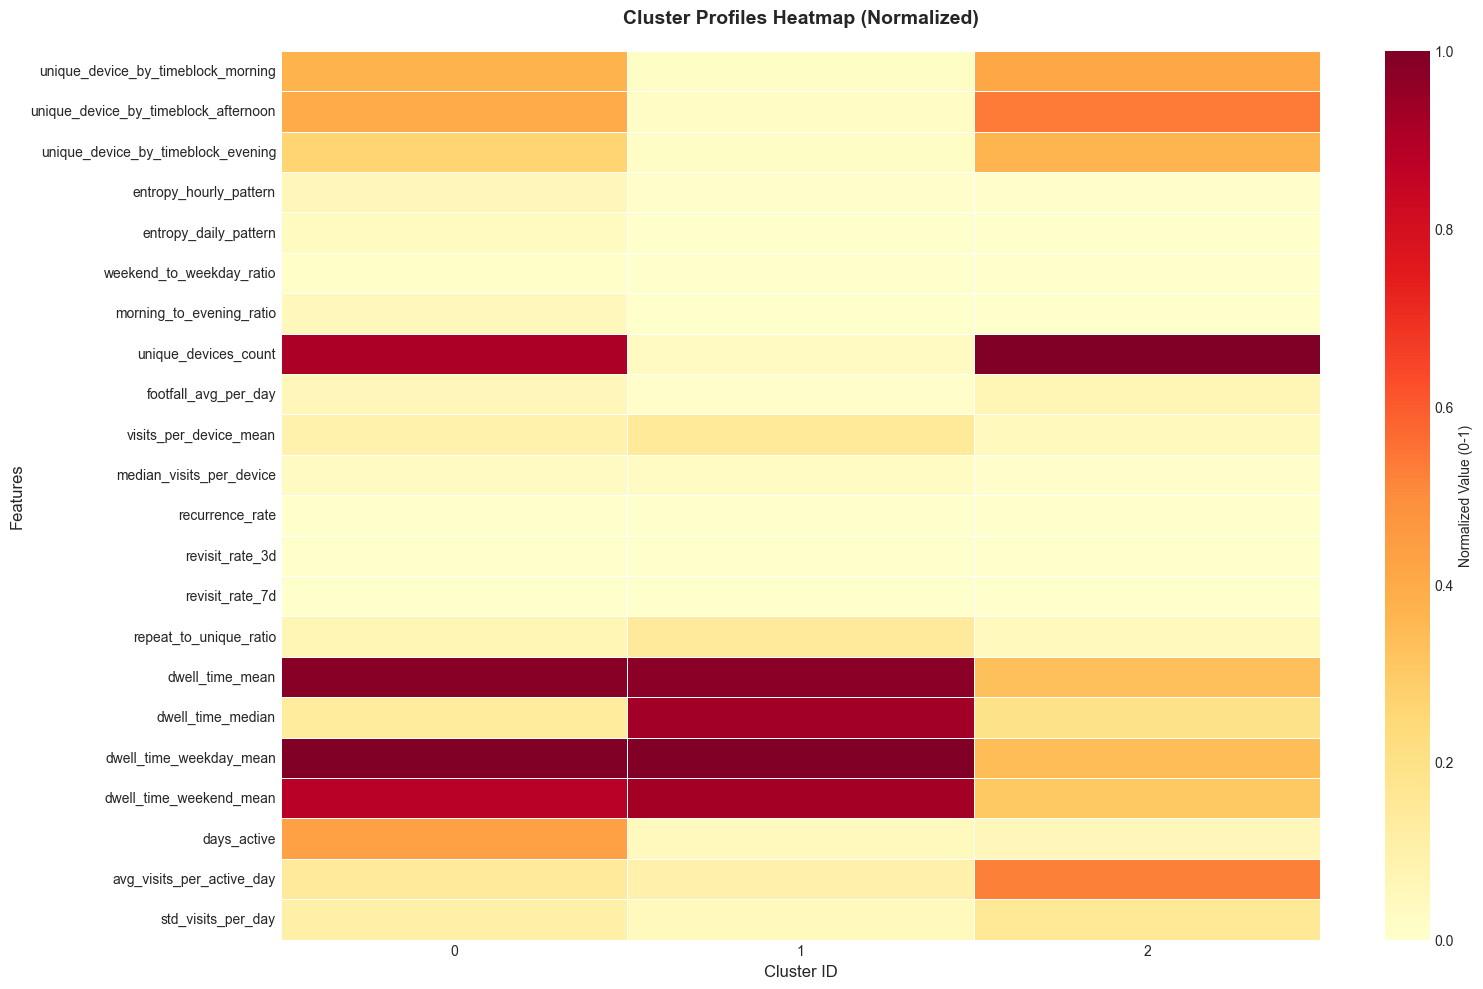

✓ Saved: results/kmeans_cluster_profiles.png


In [120]:
# Heatmap of cluster profiles (normalized)
# Normalize each feature to 0-1 for better visualization
from sklearn.preprocessing import MinMaxScaler

scaler_viz = MinMaxScaler()
cluster_profiles_normalized = pd.DataFrame(
    scaler_viz.fit_transform(cluster_profiles.T).T,
    index=cluster_profiles.index,
    columns=cluster_profiles.columns
)

plt.figure(figsize=(16, 10))
sns.heatmap(cluster_profiles_normalized.T, cmap='YlOrRd', annot=False,
           cbar_kws={'label': 'Normalized Value (0-1)'},
           linewidths=0.5)
plt.xlabel('Cluster ID', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.title('Cluster Profiles Heatmap (Normalized)', fontsize=14, fontweight='bold', pad=20)
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/kmeans_cluster_profiles.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Saved: {OUTPUT_DIR}/kmeans_cluster_profiles.png")

In [121]:
# Detailed cluster characteristics
print("="*70)
print("CLUSTER CHARACTERISTICS")
print("="*70)

for cluster_id in range(OPTIMAL_K):
    cluster_data = df_clustering[df_clustering['cluster'] == cluster_id]
    
    print(f"\n{'─'*70}")
    print(f"Cluster {cluster_id} ({len(cluster_data)} lugares)")
    print(f"{'─'*70}")
    
    # Top place types in this cluster
    top_types = cluster_data['clase'].value_counts().head(5)
    print(f"\nTop place types:")
    for place_type, count in top_types.items():
        pct = 100 * count / len(cluster_data)
        print(f"  {place_type:20s}: {count:3d} ({pct:5.1f}%)")
    
    # Key behavioral metrics
    print(f"\nKey metrics (mean):")
    print(f"  Unique visitors:        {cluster_data['unique_devices_count'].mean():8.1f}")
    print(f"  Footfall per day:       {cluster_data['footfall_avg_per_day'].mean():8.2f}")
    print(f"  Recurrence rate:        {cluster_data['recurrence_rate'].mean():8.2%}")
    print(f"  Dwell time (mean):      {cluster_data['dwell_time_mean'].mean():8.1f} min")
    print(f"  Weekend/Weekday ratio:  {cluster_data['weekend_to_weekday_ratio'].mean():8.2f}")
    print(f"  Morning/Evening ratio:  {cluster_data['morning_to_evening_ratio'].mean():8.2f}")
    
    # Temporal pattern
    morning_avg = cluster_data['unique_device_by_timeblock_morning'].mean()
    afternoon_avg = cluster_data['unique_device_by_timeblock_afternoon'].mean()
    evening_avg = cluster_data['unique_device_by_timeblock_evening'].mean()
    total_timeblock = morning_avg + afternoon_avg + evening_avg
    
    if total_timeblock > 0:
        print(f"\nTemporal pattern (% of daily visitors):")
        print(f"  Morning:   {100*morning_avg/total_timeblock:5.1f}%")
        print(f"  Afternoon: {100*afternoon_avg/total_timeblock:5.1f}%")
        print(f"  Evening:   {100*evening_avg/total_timeblock:5.1f}%")
    
    # Example lugares
    print(f"\nExample lugares:")
    examples = cluster_data.nlargest(3, 'unique_devices_count')[['nombre', 'clase', 'unique_devices_count']]
    for idx, row in examples.iterrows():
        if pd.notna(row['nombre']) and row['nombre'].strip():
            print(f"  - {row['nombre']} ({row['clase']}) - {int(row['unique_devices_count'])} visitors")
        else:
            print(f"  - {row['clase']} - {int(row['unique_devices_count'])} visitors")

print("\n" + "="*70)

CLUSTER CHARACTERISTICS

──────────────────────────────────────────────────────────────────────
Cluster 0 (6790 places)
──────────────────────────────────────────────────────────────────────

Top place types:
  building            : 3013 ( 44.4%)
  parking             : 549 (  8.1%)
  grass               : 339 (  5.0%)
  residential         : 280 (  4.1%)
  park                : 227 (  3.3%)

Key metrics (mean):
  Unique visitors:            33.0
  Footfall per day:           2.19
  Recurrence rate:          14.91%
  Dwell time (mean):          35.7 min
  Weekend/Weekday ratio:      0.44
  Morning/Evening ratio:      2.01

Temporal pattern (% of daily visitors):
  Morning:    36.0%
  Afternoon:  38.6%
  Evening:    25.5%

Example places:
  - grass (grass) - 386 visitors
  - Torre Emblema (building) - 372 visitors
  - park (park) - 369 visitors

──────────────────────────────────────────────────────────────────────
Cluster 1 (362 places)
─────────────────────────────────────────────────

## 10. PCA Visualization

Reduce dimensions to 2D for visualization usando PCA.

In [122]:
# Perform PCA for visualization
pca = PCA(n_components=2, random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X_scaled)

print(f"PCA Explained Variance:")
print(f"  Component 1: {pca.explained_variance_ratio_[0]:.2%}")
print(f"  Component 2: {pca.explained_variance_ratio_[1]:.2%}")
print(f"  Total: {sum(pca.explained_variance_ratio_):.2%}")

# Add PCA coordinates to dataframe
df_clustering['pca_1'] = X_pca[:, 0]
df_clustering['pca_2'] = X_pca[:, 1]

PCA Explained Variance:
  Component 1: 38.18%
  Component 2: 23.78%
  Total: 61.95%


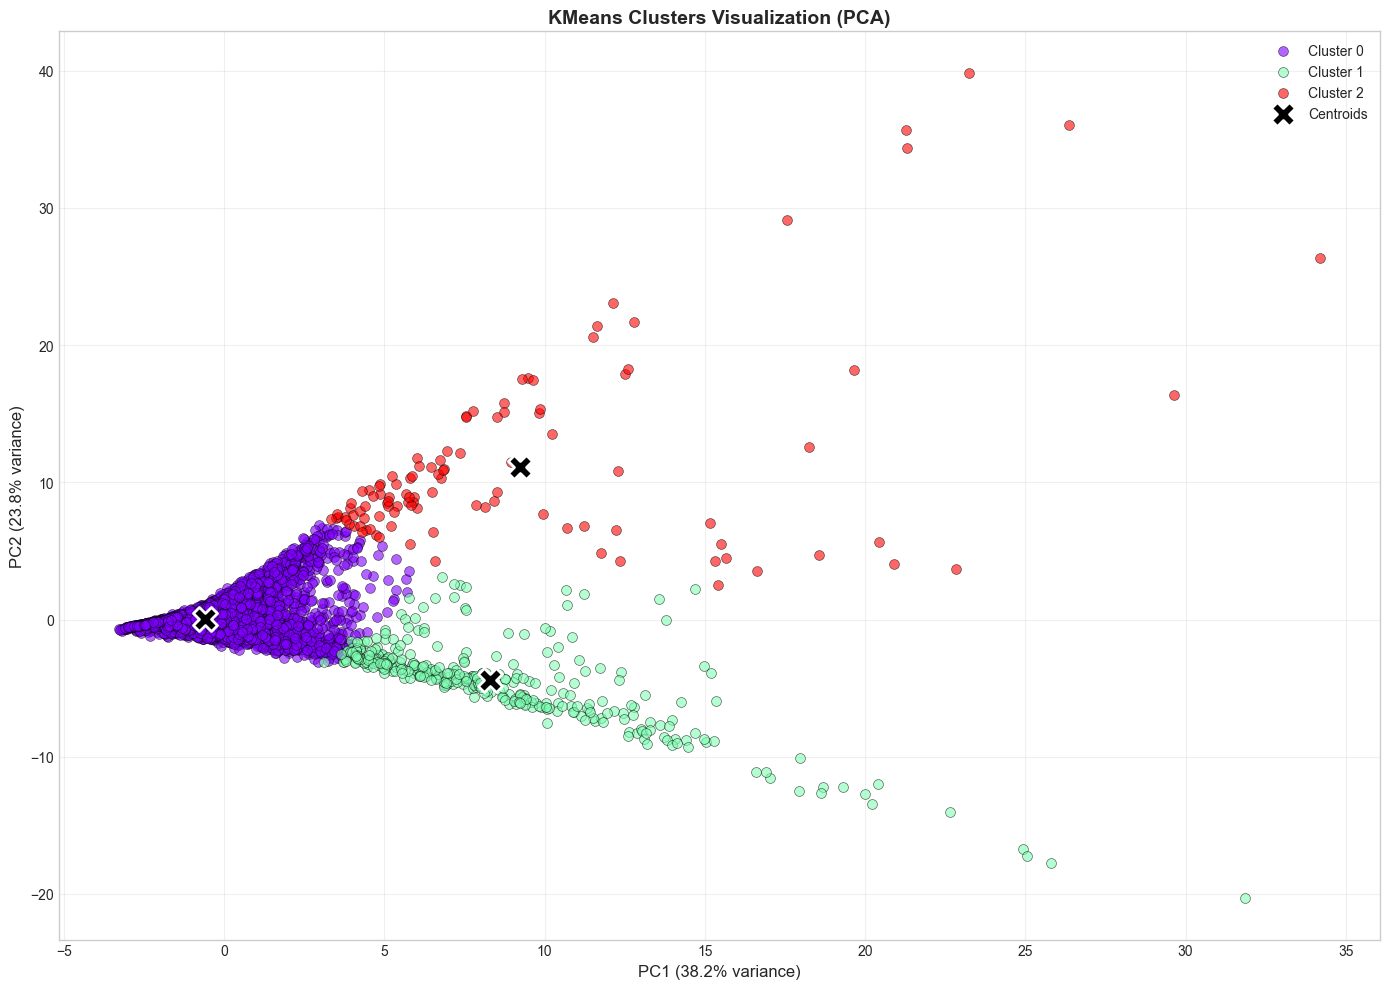

✓ Saved: results/kmeans_pca_visualization.png


In [82]:
# 2D scatter plot of clusters
fig, ax = plt.subplots(1, 1, figsize=(14, 10))

# Plot each cluster
colors = plt.cm.rainbow(np.linspace(0, 1, OPTIMAL_K))

for cluster_id in range(OPTIMAL_K):
    cluster_data = df_clustering[df_clustering['cluster'] == cluster_id]
    ax.scatter(cluster_data['pca_1'], cluster_data['pca_2'],
              c=[colors[cluster_id]], label=f'Cluster {cluster_id}',
              alpha=0.6, s=50, edgecolors='black', linewidths=0.5)

# Plot cluster centers (transformed to PCA space)
centers_pca = pca.transform(kmeans_final.cluster_centers_)
ax.scatter(centers_pca[:, 0], centers_pca[:, 1],
          c='black', marker='X', s=300, edgecolors='white', linewidths=2,
          label='Centroids', zorder=10)

ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)', fontsize=12)
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)', fontsize=12)
ax.set_title(f'KMeans Clusters Visualization (PCA)', fontsize=14, fontweight='bold')
ax.legend(loc='best', fontsize=10, framealpha=0.9)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/kmeans_pca_visualization.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Saved: {OUTPUT_DIR}/kmeans_pca_visualization.png")

## 11. Export Results

In [123]:
# Export clustered data
output_file = f'{OUTPUT_DIR}/kmeans_clustered_places.csv'
df_clustering.to_csv(output_file, index=False)
print(f"✓ Clustered lugares saved: {output_file}")

# Export cluster profiles
profiles_file = f'{OUTPUT_DIR}/kmeans_cluster_profiles.csv'
cluster_profiles.to_csv(profiles_file)
print(f"✓ Cluster profiles saved: {profiles_file}")

# Export evaluation metrics
metrics = {
    'optimal_k': OPTIMAL_K,
    'n_places': len(df_clustering),
    'n_features': len(CLUSTERING_FEATURES),
    'silhouette_score': final_silhouette,
    'davies_bouldin_score': final_db,
    'calinski_harabasz_score': final_ch,
    'inertia': kmeans_final.inertia_,
    'pca_variance_explained': sum(pca.explained_variance_ratio_)
}

metrics_file = f'{OUTPUT_DIR}/kmeans_evaluation_metrics.txt'
with open(metrics_file, 'w') as f:
    f.write("KMeans Clustering Evaluation Metrics\n")
    f.write("="*70 + "\n\n")
    for key, value in metrics.items():
        f.write(f"{key}: {value}\n")

print(f"✓ Evaluation metrics saved: {metrics_file}")

✓ Clustered places saved: results/kmeans_clustered_places.csv
✓ Cluster profiles saved: results/kmeans_cluster_profiles.csv
✓ Evaluation metrics saved: results/kmeans_evaluation_metrics.txt


## 12. Save Models with Pickle

In [124]:
# Create timestamp for versioning
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

print("="*70)
print("SAVING MODELS WITH PICKLE")
print("="*70)
print(f"\nTimestamp: {timestamp}")
print(f"Directory: {MODELS_DIR}/")

# Save KMeans model
model_file = os.path.join(MODELS_DIR, f'kmeans_model_{timestamp}.pkl')
with open(model_file, 'wb') as f:
    pickle.dump(kmeans_final, f)
print(f"\n✓ KMeans model saved: {os.path.basename(model_file)}")

# Save scaler
scaler_file = os.path.join(MODELS_DIR, f'scaler_{timestamp}.pkl')
with open(scaler_file, 'wb') as f:
    pickle.dump(scaler, f)
print(f"✓ Scaler saved: {os.path.basename(scaler_file)}")

# Save PCA model
pca_file = os.path.join(MODELS_DIR, f'pca_{timestamp}.pkl')
with open(pca_file, 'wb') as f:
    pickle.dump(pca, f)
print(f"✓ PCA model saved: {os.path.basename(pca_file)}")

# Save complete package
model_package = {
    'kmeans_model': kmeans_final,
    'scaler': scaler,
    'pca': pca,
    'cluster_profiles': cluster_profiles,
    'feature_names': CLUSTERING_FEATURES,
    'optimal_k': OPTIMAL_K,
    'evaluation_metrics': metrics,
    'metadata': {
        'timestamp': timestamp,
        'n_places': len(df_clustering),
        'n_features': len(CLUSTERING_FEATURES),
        'random_state': RANDOM_STATE
    }
}

package_file = os.path.join(MODELS_DIR, f'kmeans_complete_{timestamp}.pkl')
with open(package_file, 'wb') as f:
    pickle.dump(model_package, f)
print(f"✓ Completo package saved: {os.path.basename(package_file)}")

# Save as "latest" for easy loading
latest_file = os.path.join(MODELS_DIR, 'kmeans_latest.pkl')
with open(latest_file, 'wb') as f:
    pickle.dump(model_package, f)
print(f"✓ Latest model saved: {os.path.basename(latest_file)}")

# File sizes
package_size = os.path.getsize(package_file) / 1024  # KB
print(f"\n📦 Package size: {package_size:.2f} KB")

print("\n" + "="*70)
print("ALL MODELS SAVED SUCCESSFULLY!")
print("="*70)

SAVING MODELS WITH PICKLE

Timestamp: 20251103_125352
Directory: results\models/

✓ KMeans model saved: kmeans_model_20251103_125352.pkl
✓ Scaler saved: scaler_20251103_125352.pkl
✓ PCA model saved: pca_20251103_125352.pkl
✓ Complete package saved: kmeans_complete_20251103_125352.pkl
✓ Latest model saved: kmeans_latest.pkl

📦 Package size: 34.76 KB

ALL MODELS SAVED SUCCESSFULLY!


## 13. Visualización Interactiva

In [87]:
import folium
from folium.plugins import MarkerCluster, HeatMap
from shapely import wkt

print("Creando interactive maps...")

# Calculate map center (usando already extracted lat/lon)
center_lat = df_clustering['latitude'].mean()
center_lon = df_clustering['longitude'].mean()

print(f"Map center: ({center_lat:.6f}, {center_lon:.6f})")


Creating interactive maps...
Map center: (13.697916, -89.228777)


### 13.1 Cluster Polygons Map (usando geometry_wkt)

In [88]:
# Map 1: Cluster polygons with different colors
print("Creando Map 1: Cluster Polygons Overview...")

m1 = folium.Map(
    location=[center_lat, center_lon],
    zoom_start=11,
    tiles='OpenStreetMap'
)

# Define colors for the K-means clusters
n_clusters_kmeans = len(df_clustering['cluster'].unique())
cluster_colors = {
    0: '#FF0000',  # Red
    1: '#00FF00',  # Green
    2: '#0000FF'   # Blue
}

# Get cluster sizes
cluster_sizes_viz = df_clustering['cluster'].value_counts().sort_index()

# Sample lugares per cluster for visualization (to avoid browser overload)
MAX_PLACES_PER_CLUSTER = 500

for cluster_id in sorted(df_clustering['cluster'].unique()):
    cluster_data = df_clustering[df_clustering['cluster'] == cluster_id]

    # Sample if needed
    if len(cluster_data) > MAX_PLACES_PER_CLUSTER:
        cluster_sample = cluster_data.sample(MAX_PLACES_PER_CLUSTER, random_state=42)
    else:
        cluster_sample = cluster_data

    color = cluster_colors.get(cluster_id, '#888888')

    # Add each polygon
    for idx, row in cluster_sample.iterrows():
        try:
            geom = wkt.loads(row['geometry_wkt'])

            # Convert geometry to GeoJSON
            if geom.geom_type == 'Polygon':
                coords = [[coord[1], coord[0]] for coord in geom.exterior.coords]

                folium.Polygon(
                    locations=coords,
                    color=color,
                    fill=True,
                    fillColor=color,
                    fillOpacity=0.3,
                    weight=1,
                    popup=f"<b>Cluster {cluster_id}</b><br>Place ID: {row.get('place_id', 'N/A')}"
                ).add_to(m1)
            elif geom.geom_type == 'Point':
                # For points, create a small circle
                folium.CircleMarker(
                    location=[row['latitude'], row['longitude']],
                    radius=5,
                    color=color,
                    fill=True,
                    fillColor=color,
                    fillOpacity=0.6,
                    popup=f"<b>Cluster {cluster_id}</b><br>Place ID: {row.get('place_id', 'N/A')}"
                ).add_to(m1)
        except Exception as e:
            continue

# Add cluster centroids
for cluster_id in sorted(df_clustering['cluster'].unique()):
    cluster_data = df_clustering[df_clustering['cluster'] == cluster_id]
    center_lat_cluster = cluster_data['latitude'].mean()
    center_lon_cluster = cluster_data['longitude'].mean()
    cluster_size_viz = len(cluster_data)

    folium.Marker(
        location=[center_lat_cluster, center_lon_cluster],
        popup=f"""
        <div style='width: 200px'>
            <h4>Cluster {cluster_id}</h4>
            <b>Size:</b> {cluster_size_viz:,} places<br>
            <b>Center:</b> ({center_lat_cluster:.6f}, {center_lon_cluster:.6f})<br>
        </div>
        """,
        tooltip=f"Cluster {cluster_id} - {cluster_size_viz:,} places",
        icon=folium.Icon(color='black', icon='star')
    ).add_to(m1)

# Add legend
legend_html = f'''
<div style="position: fixed;
    bottom: 50px; right: 50px; width: 220px; height: 140px;
    background-color: white; border:2px solid grey; z-index:9999;
    font-size:14px; padding: 10px">
    <p><b>K-Means Clusters (k={n_clusters_kmeans})</b></p>
'''

for cluster_id in sorted(df_clustering['cluster'].unique()):
    legend_html += f'<p><span style="color:{cluster_colors.get(cluster_id, "#888")}">■</span> Cluster {cluster_id} ({cluster_sizes_viz[cluster_id]:,} lugares)</p>'

legend_html += '</div>'

m1.get_root().html.add_child(folium.Element(legend_html))

# Save map
import os
os.makedirs('results', exist_ok=True)
map1_file = 'results/map_kmeans_clusters_polygons.html'
m1.save(map1_file)
print(f"✓ Saved: {map1_file}")

print("\nDisplaying map...")
m1


Creating Map 1: Cluster Polygons Overview...
✓ Saved: results/map_kmeans_clusters_polygons.html

Displaying map...


### 13.2 Places Heatmap

In [89]:
# Map 2: Heatmap of all lugares
print("Creando Map 2: Places Heatmap...")

m2 = folium.Map(
    location=[center_lat, center_lon],
    zoom_start=11,
    tiles='CartoDB positron'
)

# Sample data for heatmap (max 5,000 points for performance)
HEATMAP_SAMPLE_SIZE = 5000
heatmap_sample = df_clustering.sample(min(HEATMAP_SAMPLE_SIZE, len(df_clustering)), random_state=42)

# Prepare heat data
heat_data = [[row['latitude'], row['longitude']] for _, row in heatmap_sample.iterrows()]

# Add heatmap layer
HeatMap(
    heat_data,
    min_opacity=0.3,
    max_zoom=18,
    radius=15,
    blur=20,
    gradient={
        0.0: 'blue',
        0.3: 'lime',
        0.5: 'yellow',
        0.7: 'orange',
        1.0: 'red'
    }
).add_to(m2)

# Save map
map2_file = 'results/map_kmeans_heatmap.html'
m2.save(map2_file)
print(f"✓ Saved: {map2_file}")

print("\nDisplaying heatmap...")
m2


Creating Map 2: Places Heatmap...
✓ Saved: results/map_kmeans_heatmap.html

Displaying heatmap...


### 13.3 Cluster Centers with MarkerCluster

In [90]:
# Map 3: All lugares with MarkerCluster grouped by cluster
print("Creando Map 3: All Places with MarkerCluster...")

m3 = folium.Map(
    location=[center_lat, center_lon],
    zoom_start=11,
    tiles='OpenStreetMap'
)

# Create separate marker clusters for each K-means cluster
marker_clusters_dict = {}
for cluster_id in sorted(df_clustering['cluster'].unique()):
    marker_clusters_dict[cluster_id] = MarkerCluster(name=f'Cluster {cluster_id}').add_to(m3)

# Sample lugares for marker cluster (max 1000 per cluster)
MAX_MARKERS_PER_CLUSTER = 1000

color_map = {0: 'red', 1: 'green', 2: 'blue'}

for cluster_id in sorted(df_clustering['cluster'].unique()):
    cluster_data = df_clustering[df_clustering['cluster'] == cluster_id]

    # Sample if needed
    if len(cluster_data) > MAX_MARKERS_PER_CLUSTER:
        cluster_sample = cluster_data.sample(MAX_MARKERS_PER_CLUSTER, random_state=42)
    else:
        cluster_sample = cluster_data

    color = color_map.get(cluster_id, 'gray')

    # Add markers
    for _, row in cluster_sample.iterrows():
        folium.Marker(
            location=[row['latitude'], row['longitude']],
            popup=f"""
            <div style='width: 200px'>
                <h4>Cluster {cluster_id}</h4>
                <b>Place ID:</b> {row.get('place_id', 'N/A')}<br>
                <b>Location:</b> ({row['latitude']:.6f}, {row['longitude']:.6f})<br>
            </div>
            """,
            tooltip=f"Cluster {cluster_id}",
            icon=folium.Icon(color=color, icon='info-sign')
        ).add_to(marker_clusters_dict[cluster_id])

# Add layer control
folium.LayerControl().add_to(m3)

# Save map
map3_file = 'results/map_kmeans_markercluster.html'
m3.save(map3_file)
print(f"✓ Saved: {map3_file}")

print(f"\nCreated markers for all clusters")
print("\nDisplaying map (zoom in to see individual lugares)...")
m3


Creating Map 3: All Places with MarkerCluster...
✓ Saved: results/map_kmeans_markercluster.html

Created markers for all clusters

Displaying map (zoom in to see individual places)...
